<a href="https://colab.research.google.com/github/Abhiraj36/HumanEmotionsDetection/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Conv2D, MaxPool2D, Dense
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



import matplotlib.pyplot as plt
import numpy as np

!git clone https://github.com/Abhiraj36/HumanEmotionsDetection.git
%cd HumanEmotionsDetection
from tensorflow.keras.models import load_model

lenet_model = load_model('model_full.keras', compile=True)  # or use the path inside the repo if nested
lenet_model.summary()  # optional: to see the model structure

Cloning into 'HumanEmotionsDetection'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 56 (delta 19), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 4.70 MiB | 7.28 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/HumanEmotionsDetection/HumanEmotionsDetection/HumanEmotionsDetection


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 68)   │        19,652 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 109, 109, 68)   │           272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 68)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 54, 54, 68)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 68)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,416 (302.41 KB)

 Trainable params: 38,415 (150.06 KB)

 Non-trainable params: 584 (2.28 KB)

 Optimizer params: 38,417 (150.07 KB)

In [32]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhirajaryan","key":"a77a4658fd915b6eb723a372ffec2a61"}'}

In [33]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [34]:
import kagglehub

# Download latest version of the new dataset
path = kagglehub.dataset_download("himanshuydv11/facial-emotion-dataset")
print(" Path to dataset files:", path)


 Path to dataset files: /kaggle/input/facial-emotion-dataset


In [35]:
import os

# See what folders you got
print(os.listdir(path))


['facial_emotion_dataset']


In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-emotions-datasethes


In [37]:
import os
import shutil

new_dataset_path = "/root/.cache/kagglehub/datasets/himanshuydv11/facial-emotion-dataset/versions/1/facial_emotion_dataset/dataset"
existing_dataset_path = "/root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4/Human_Emotion_Dataset"

# Only copy selected classes
selected_classes = ['Sad', 'Angry', 'Happy']

for cls in selected_classes:
    src = os.path.join(new_dataset_path, cls)
    dst = os.path.join(existing_dataset_path, cls)

    if not os.path.exists(dst):
        os.makedirs(dst)

    for file_name in os.listdir(src):
        src_file = os.path.join(src, file_name)
        dst_file = os.path.join(dst, file_name)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

print(" Selected classes merged successfully!")





 Selected classes merged successfully!


In [38]:
import os
import shutil
import random

new_dataset_path = "/root/.cache/kagglehub/datasets/himanshuydv11/facial-emotion-dataset/versions/1/facial_emotion_dataset/dataset"
base_dataset_path = "/content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data"
selected_classes = ["angry", "happy", "sad"]

for cls in selected_classes:
    src_dir = os.path.join(new_dataset_path, cls.capitalize())  # Capitalize because folders are like 'Angry'
    train_dst = os.path.join(base_dataset_path, "train", cls)
    test_dst = os.path.join(base_dataset_path, "test", cls)

    if not os.path.exists(train_dst): os.makedirs(train_dst)
    if not os.path.exists(test_dst): os.makedirs(test_dst)

    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    random.shuffle(files)
    split_idx = int(0.8 * len(files))  # 80% train

    for f in files[:split_idx]:
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_dst, f))
    for f in files[split_idx:]:
        shutil.copy(os.path.join(src_dir, f), os.path.join(test_dst, f))

print(" New data successfully added to train and test folders!")



 New data successfully added to train and test folders!


In [39]:
import os

dataset_path = "/content/Human_Emotion_Dataset"
train_directory = os.path.join(dataset_path, "EmotionsDataset_Splitted", "data", "train")
val_directory = os.path.join(dataset_path, "EmotionsDataset_Splitted", "data", "test")

print("Updated train path:", train_directory)
print("Updated validation path:", val_directory)

CLASS_NAMES = ["angry", "happy", "sad"]


Updated train path: /content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data/train
Updated validation path: /content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data/test


In [40]:
CONFIGURATION = {
    "IM_SIZE": 224,
    "N_FILTERS": 32,
    "KERNEL_SIZE": (3, 3),
    "N_STRIDES": 1,
    "POOL_SIZE": (2, 2),
    "DROPOUT_RATE": 0.3,
    "N_DENSE_1": 128,
    "N_DENSE_2": 64,
    "REGULARIZATION_RATE": 0.001,
    "NUM_CLASSES": 3,
    "EPOCHS": 30,
    "BATCH_SIZE": 32
}


In [41]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=99,
    class_names=CLASS_NAMES,
    color_mode='rgb'
)


Found 8634 files belonging to 3 classes.


In [42]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,  # Now pointing to test directory
    labels='inferred',
    label_mode='int',
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    shuffle=True,  # Usually, we don't shuffle validation data
    seed=99,
    class_names=CLASS_NAMES,
    color_mode='rgb'
)


Found 3243 files belonging to 3 classes.


In [43]:
for images, labels in val_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch:", labels.numpy())


Image batch shape: (32, 224, 224, 3)
Label batch: [2 2 2 1 0 1 1 2 2 1 1 1 2 2 2 2 1 2 2 0 1 1 1 1 2 1 1 1 0 2 2 2]


Data Visualization

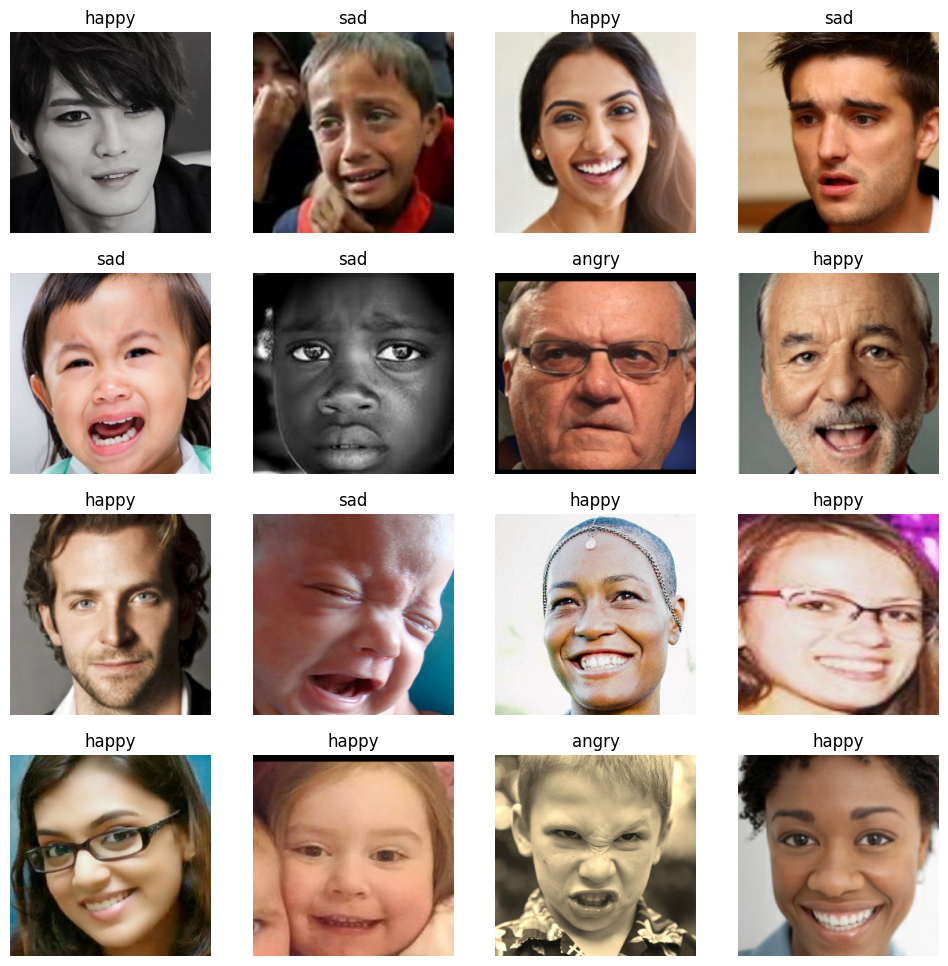

In [44]:
plt.figure(figsize=(12, 12))

for images, labels in train_dataset.take(1):  # Taking one batch of images
    for i in range(min(16, len(images))):  # Display up to 16 images
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(CLASS_NAMES[labels[i].numpy()])  # Get class name
        plt.axis("off")  # Hide axes

plt.show()


Dataset Preparation

In [45]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [46]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)


In [47]:
IM_SIZE = 256  # Define the image size if not already defined

resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0 / 255),  # Normalize pixel values to [0,1]
])

Building and Applying Model

Training

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),

])

# Define the model
lenet_model = tf.keras.Sequential([
    layers.Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),  # Input
    data_augmentation,
    layers.Rescaling(1./255, name="rescaling"),

    # First Conv Block
    layers.Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
                  strides=CONFIGURATION["N_STRIDES"], activation='relu',
                  kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),
    layers.Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    # Second Conv Block
    layers.Conv2D(filters=CONFIGURATION["N_FILTERS"] * 2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
                  strides=CONFIGURATION["N_STRIDES"], activation='relu',
                  kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),
    layers.Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    # Global Pooling
    layers.GlobalAveragePooling2D(),

    # First Dense Block
    layers.Dense(CONFIGURATION["N_DENSE_1"], activation="relu",
                 kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.Dropout(rate=min(CONFIGURATION["DROPOUT_RATE"] + 0.1, 0.5)),  # Slightly higher dropout in dense

    # Second Dense Block
    layers.Dense(CONFIGURATION["N_DENSE_2"], activation="relu",
                 kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),

    # Output
    layers.Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])



# Summary
lenet_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 68)   │        19,652 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 68)   │           272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 68)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 54, 68)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 68)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,999 (152.34 KB)

 Trainable params: 38,415 (150.06 KB)

 Non-trainable params: 584 (2.28 KB)

In [49]:
loss_function = SparseCategoricalCrossentropy()

In [50]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name ="top_k_accuracy")]

In [51]:
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

lenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy' if CONFIGURATION["NUM_CLASSES"] > 1 else 'binary_crossentropy',
    metrics=[
        'accuracy',
        SparseTopKCategoricalAccuracy(k=2, name='top_2_accuracy')
    ]
)



In [52]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)




In [53]:
lenet_model.evaluate(validation_dataset)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.1469 - loss: 1.3434 - top_2_accuracy: 0.5760


[1.3432101011276245, 0.14986124634742737, 0.5806351900100708]

In [54]:
history = lenet_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=CONFIGURATION["EPOCHS"],
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 60s 206ms/step - accuracy: 0.4166 - loss: 1.4732 - top_2_accuracy: 0.7446 - val_accuracy: 0.4339 - val_loss: 1.3306 - val_top_2_accuracy: 0.8489 - learning_rate: 0.0010
Epoch 2/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 82s 210ms/step - accuracy: 0.4915 - loss: 1.2165 - top_2_accuracy: 0.8409 - val_accuracy: 0.4758 - val_loss: 1.1808 - val_top_2_accuracy: 0.8517 - learning_rate: 0.0010
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - accuracy: 0.5041 - loss: 1.1832 - top_2_accuracy: 0.8420 - val_accuracy: 0.5177 - val_loss: 1.1449 - val_top_2_accuracy: 0.8575 - learning_rate: 0.0010
Epoch 4/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 54s 200ms/step - accuracy: 0.5212 - loss: 1.1428 - top_2_accuracy: 0.8577 - val_accuracy: 0.4678 - val_loss: 1.1457 - val_top_2_accuracy: 0.8711 - learning_rate: 0.0010
Epoch 5/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 85s 210ms/step - accuracy: 0.5220 - loss: 1.1244 - top_2_accuracy: 0.8583 - val_accuracy: 0.5458 - val_loss: 1.0728 - val_to

In [59]:
lenet_model.evaluate(validation_dataset)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.6016 - loss: 0.8980 - top_2_accuracy: 0.8830


[0.8835830092430115, 0.609929084777832, 0.890533447265625]

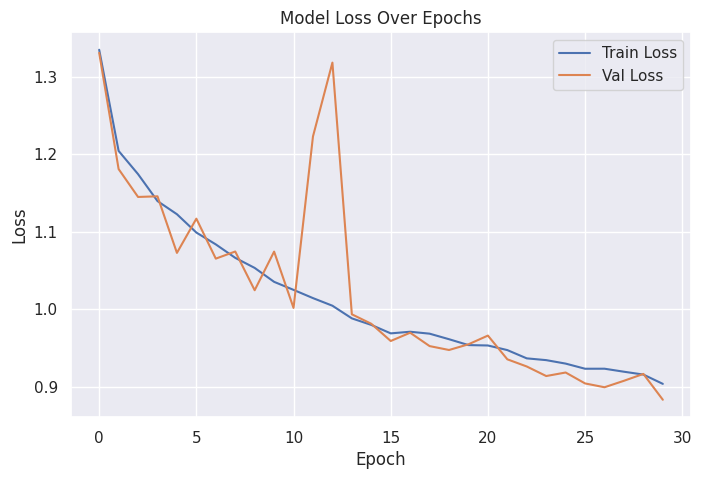

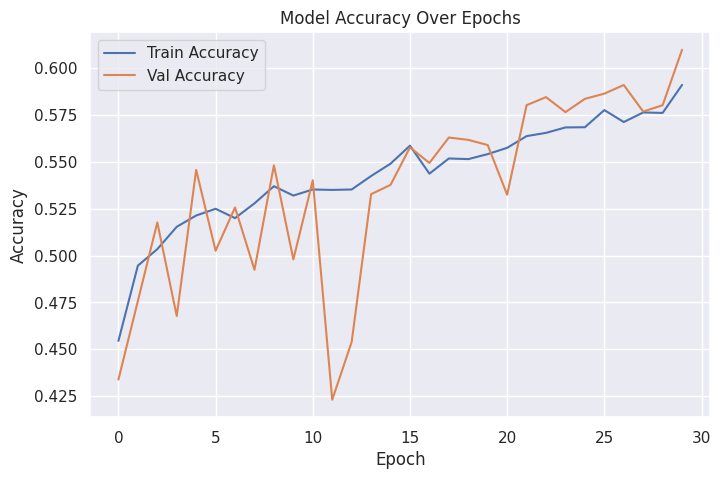

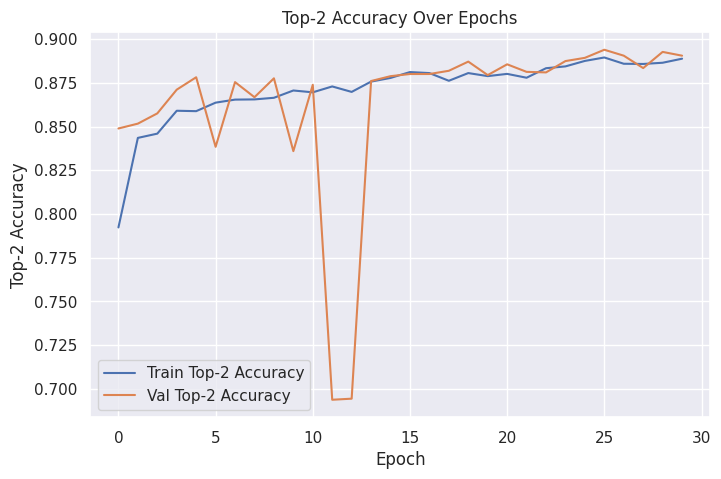

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()

# Top-2 Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['top_2_accuracy'], label='Train Top-2 Accuracy')
plt.plot(history.history['val_top_2_accuracy'], label='Val Top-2 Accuracy')

plt.title('Top-2 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Top-2 Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('top2_accuracy_plot.png')
plt.show()


In [81]:
import cv2
import numpy as np
import tensorflow as tf

# Load the model (you should load your model here)
model = tf.keras.models.load_model('your_model_path')

# Define a function to get the actual label of the image from its path
def get_actual_label(image_path):
    # Extract the folder name from the path, which is the actual label
    return image_path.split('/')[-2]

# Load and preprocess the test image
test_image_path = "/content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data/test/angry/00b7e4551ffa57ff4e2311b2ce156a6c964c642abcacff6920bba177~angry.jpg"
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (224, 224))  # Resize image to match model's input shape
test_image = test_image / 255.0  # Normalize the image to [0, 1]
test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension

# Get the actual label (folder name, which is the actual class)
actual_label = get_actual_label(test_image_path)

# Predict the emotion using the trained model
prediction = model.predict(test_image)
predicted_class = np.argmax(prediction, axis=1)  # Get the class with the highest probability

# Map the predicted class index to the corresponding class label
class_labels = ['angry', 'happy', 'sad']  # You should make sure this matches your model's class labels
predicted_label = class_labels[predicted_class[0]]

# Print the actual label and predicted label
print(f"Actual label: {actual_label}")
print(f"Predicted label: {predicted_label}")




ValueError: File format not supported: filepath=your_model_path. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(your_model_path, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [78]:
import numpy as np

# Example model output
model_output = np.array([0.21878687, 0.21867742, 0.5625357 ])

# Find the index of the max value
predicted_class_index = np.argmax(model_output)

# Get the predicted class label
predicted_class = train_dataset.class_names[predicted_class_index]

print(f"Predicted class: {predicted_class}")




Predicted class: sad


NameError: name 'train_ds' is not defined